In [25]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


## Increase contrast of site

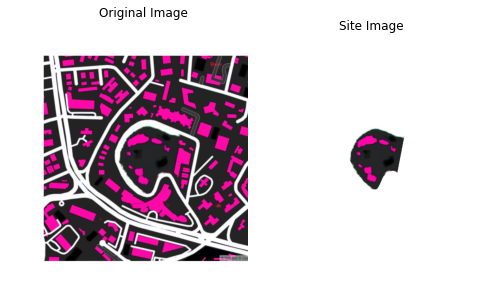

In [26]:
directory_path = os.getcwd()

mask_image = Image.open(os.path.join(directory_path, 'best_mask_1.png'))
original_image = Image.open(os.path.join(directory_path, 'best_1.png')) #predicted image

# Convert the image to RGB, which will remove the alpha channel(doing this because got transparency channel)
mask_image = mask_image.convert('RGB')
original_image = original_image.convert('RGB')


mask_array = np.array(mask_image)
original_array = np.array(original_image)

# Create mask using blue mask
def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)
mask_color = [4, 255, 0]  # bright green
site_mask = create_binary_mask(mask_array, mask_color)

# Extract site from the original image that corresponds to the blue mask
site_area_array = original_array.copy()
site_area_array[~site_mask] = [255, 255, 255]  # making non-masked region white

# Convert site_area back to a PIL image and enhance its contrast
site_area_image = Image.fromarray(site_area_array)


# Display the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(site_area_image)
plt.title('Site Image')
plt.axis('off')
plt.show()


## Extract Buildings

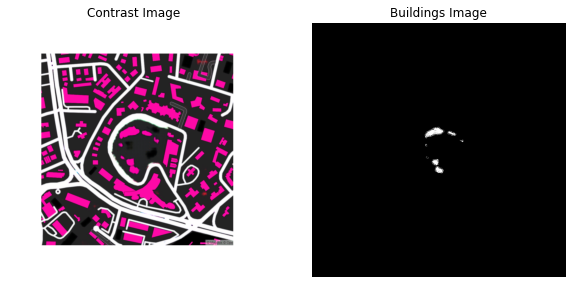

In [30]:
#detect buildings
def extract_building_regions(arr, target_color, threshold=10):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)
mask_color = [250, 8, 162]  # bright pink
building_mask = extract_building_regions(site_area_array, mask_color)

buildings_image = Image.fromarray(building_mask)


# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.show()

##  Draw contours

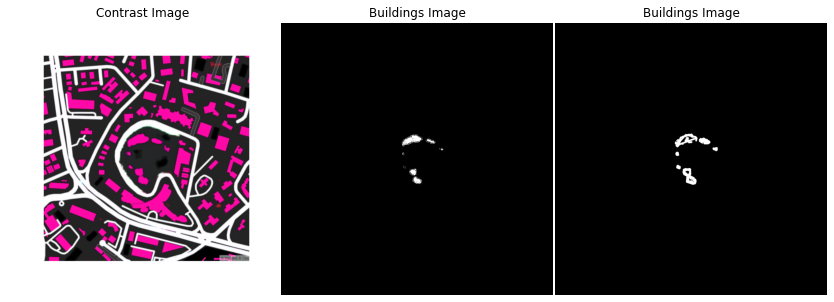

In [47]:
def approx_contours(contours, epsilon_factor=0.02):
    approximated_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approximated_contours.append(approx)
    return approximated_contours

# convert mask to uint8 instead of bool
building_mask = building_mask.astype(np.uint8) * 255

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(building_mask, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Approximate contours to simplify shapes
approximated_contours = approx_contours(contours)

# Draw the contours on the original image
original_approximated_contours = cv2.drawContours(building_mask.copy(), approximated_contours, -1, (255), 10)

# Draw the contours on the blank image
blank_image = np.zeros_like(building_mask)
approximated_contours_image = cv2.drawContours(blank_image, approximated_contours, -1, (255), 5)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(approximated_contours_image, cmap='gray')
plt.title('Buildings Image Contour')
plt.axis('off')
plt.show()


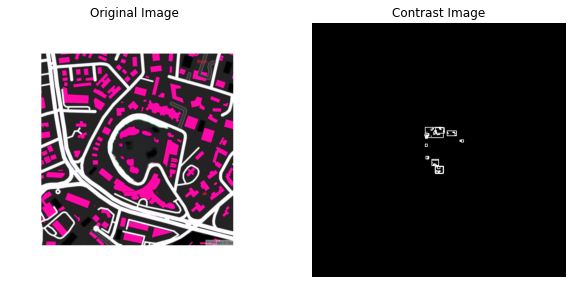

In [55]:
blank_image = np.zeros_like(building_mask)

# Iterate through each contour
for contour in approximated_contours:
    # Calculate the bounding rectangle for each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the rectangle on the blank image
    # (255) is the color (white), and 2 is the thickness of the rectangle lines
    cv2.rectangle(blank_image, (x, y), (x+w, y+h), (255), 2)

# Draw the contours on the blank image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blank_image, cmap='gray')
plt.title('Contrast Image')
plt.axis('off')
plt.show()
